# Train LSTM Model with PyTorch (Point Prediction)

This notebook trains an LSTM model for RUL prediction using PyTorch.

**Why PyTorch?**
- Much faster on Apple Silicon (MPS acceleration)
- LSTM layers are optimized for M3 Pro
- Easier Monte Carlo Dropout implementation

**Phase 1**: Point prediction only - no uncertainty quantification.
**Phase 2**: Monte Carlo Dropout will be added in `06_add_uncertainty_lstm_mc_pytorch.ipynb`


In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib
import time

# PyTorch for LSTM
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Add project root to path
project_root = Path("/Users/siddhantaggarwal/Desktop/Battery_RUL").resolve()
sys.path.append(str(project_root))

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Set device (use MPS on Apple Silicon for acceleration)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ Using MPS (Apple Silicon GPU acceleration)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("✅ Using CUDA (NVIDIA GPU)")
else:
    device = torch.device("cpu")
    print("⚠️ Using CPU (slower, but will work)")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
print("✅ PyTorch ready!")


✅ Using MPS (Apple Silicon GPU acceleration)
PyTorch version: 2.9.0
Device: mps
✅ PyTorch ready!


In [2]:
# Load dataset with EMD features
processed_dir = project_root / "data" / "processed"
df = pd.read_parquet(processed_dir / "rul_features_with_emd.parquet")

print(f"Dataset shape: {df.shape}")

# Filter out rows with NaN RUL
df_clean = df[df['RUL'].notna()].copy()
print(f"After removing NaN RUL: {len(df_clean)} rows")
print(f"RUL range: [{df_clean['RUL'].min():.1f}, {df_clean['RUL'].max():.1f}] cycles")


Dataset shape: (2750, 190)
After removing NaN RUL: 1408 rows
RUL range: [-107.0, 123.0] cycles


In [3]:
# Prepare features
exclude_cols = [
    'battery_id', 'filename', 'type', 'start_time', 'test_id', 'uid',
    'split', 'cycle_index', 'EOL_cycle', 'RUL', 'SOH', 'Capacity', 
    'Re', 'Rct', 'ambient_temperature'
]

feature_cols = [c for c in df_clean.columns if c not in exclude_cols]
print(f"Total features: {len(feature_cols)}")

# Split by battery
train_idx = df_clean['split'] == 'train'
test_idx = df_clean['split'] == 'test'

df_train = df_clean[train_idx].copy()
df_test = df_clean[test_idx].copy()

print(f"Train: {len(df_train)}, Test: {len(df_test)}")


Total features: 175
Train: 1158, Test: 250


In [4]:
# Create sequences for LSTM
sequence_length = 20  # Number of past cycles to use

def create_sequences(df_subset, feature_cols, target_col, seq_len=sequence_length):
    """Create sequences for LSTM training."""
    sequences = []
    targets = []
    
    # Pre-fill NaN values once
    df_filled = df_subset[feature_cols + [target_col, 'battery_id', 'cycle_index']].fillna(0)
    
    for battery_id in df_subset['battery_id'].unique():
        battery_data = df_filled[df_filled['battery_id'] == battery_id].sort_values('cycle_index')
        
        features = battery_data[feature_cols].values.astype(np.float32)
        target = battery_data[target_col].values.astype(np.float32)
        
        if len(features) >= seq_len:
            n_seqs = len(features) - seq_len
            for i in range(n_seqs):
                sequences.append(features[i:i+seq_len])
                targets.append(target[i+seq_len])
    
    return np.array(sequences, dtype=np.float32), np.array(targets, dtype=np.float32)

# Create sequences
print(f"Creating sequences with length {sequence_length}...")
X_train_seq, y_train_seq = create_sequences(df_train, feature_cols, 'RUL', sequence_length)
X_test_seq, y_test_seq = create_sequences(df_test, feature_cols, 'RUL', sequence_length)

print(f"Train sequences: {X_train_seq.shape}")
print(f"Test sequences: {X_test_seq.shape}")
print(f"Feature shape per timestep: {X_train_seq.shape[2]}")


Creating sequences with length 20...
Train sequences: (918, 20, 175)
Test sequences: (190, 20, 175)
Feature shape per timestep: 175


In [5]:
# Normalize features
n_samples, n_timesteps, n_features = X_train_seq.shape
X_train_reshaped = X_train_seq.reshape(-1, n_features)
X_test_reshaped = X_test_seq.reshape(-1, n_features)

# Fit scaler on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape back
X_train_seq = X_train_scaled.reshape(n_samples, n_timesteps, n_features)
X_test_seq = X_test_scaled.reshape(X_test_seq.shape[0], n_timesteps, n_features)

print("✅ Features normalized")


✅ Features normalized


In [6]:
# Create PyTorch Dataset
class BatteryDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = BatteryDataset(X_train_seq, y_train_seq)
test_dataset = BatteryDataset(X_test_seq, y_test_seq)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"✅ Data loaders created (batch size: {batch_size})")


✅ Data loaders created (batch size: 128)


In [7]:
# Build LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32, num_layers=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        # LSTM layers
        self.lstm1 = nn.LSTM(input_size, hidden_size1, num_layers, 
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size2, 16)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(16, 1)
    
    def forward(self, x):
        # LSTM layers
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        
        # Take the last output
        out = out[:, -1, :]  # Shape: (batch, hidden_size2)
        
        # Fully connected layers
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out.squeeze()  # Remove last dimension if batch_size=1

# Create model
model = LSTMModel(
    input_size=len(feature_cols),
    hidden_size1=64,
    hidden_size2=32,
    dropout=0.2  # Dropout for MC Dropout later
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ Model created: {total_params:,} parameters ({trainable_params:,} trainable)")
print(f"   Architecture: LSTM(64) → LSTM(32) → Dense(16) → Dense(1)")
print(f"   Dropout: 0.2 (for MC Dropout in Phase 2)")


✅ Model created: 74,785 parameters (74,785 trainable)
   Architecture: LSTM(64) → LSTM(32) → Dense(16) → Dense(1)
   Dropout: 0.2 (for MC Dropout in Phase 2)


In [8]:
# Training setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Split train into train/val for early stopping
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train_seq, y_train_seq, test_size=0.2, random_state=42
)

train_dataset_final = BatteryDataset(X_train_final, y_train_final)
val_dataset_final = BatteryDataset(X_val_final, y_val_final)

train_loader_final = DataLoader(train_dataset_final, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader_final = DataLoader(val_dataset_final, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Training on {len(train_dataset_final)} samples, validating on {len(val_dataset_final)} samples")
print(f"Device: {device}")
print(f"✅ Ready to train! Expected: 10-30 seconds per epoch on M3 Pro with MPS")


Training on 734 samples, validating on 184 samples
Device: mps
✅ Ready to train! Expected: 10-30 seconds per epoch on M3 Pro with MPS


In [9]:
# Training loop
num_epochs = 50
patience = 10
best_val_loss = float('inf')
patience_counter = 0

train_losses = []
val_losses = []

print("Starting training...")
start_time = time.time()

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    
    for batch_X, batch_y in train_loader_final:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader_final)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader_final:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    
    val_loss /= len(val_loader_final)
    val_losses.append(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        models_dir = project_root / "results" / "models"
        models_dir.mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), models_dir / "lstm_pytorch_best.pth")
    else:
        patience_counter += 1
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Early stopping check
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

total_time = time.time() - start_time
print(f"\n✅ Training completed in {total_time/60:.1f} minutes!")
print(f"   Average time per epoch: {total_time/len(train_losses):.1f} seconds")

# Load best model
models_dir = project_root / "results" / "models"
model.load_state_dict(torch.load(models_dir / "lstm_pytorch_best.pth"))
print("✅ Loaded best model weights")


Starting training...
Epoch [1/50], Train Loss: 1763.4870, Val Loss: 1908.2675
Epoch [5/50], Train Loss: 1711.7816, Val Loss: 1860.3047
Epoch [10/50], Train Loss: 1613.3982, Val Loss: 1750.8260
Epoch [15/50], Train Loss: 1453.1290, Val Loss: 1574.0999
Epoch [20/50], Train Loss: 1270.7482, Val Loss: 1372.7059
Epoch [25/50], Train Loss: 1089.6178, Val Loss: 1170.6250
Epoch [30/50], Train Loss: 917.1026, Val Loss: 977.9665
Epoch [35/50], Train Loss: 761.2275, Val Loss: 798.4209
Epoch [40/50], Train Loss: 616.7030, Val Loss: 647.1558
Epoch [45/50], Train Loss: 535.3527, Val Loss: 527.8270
Epoch [50/50], Train Loss: 451.2008, Val Loss: 436.2353

✅ Training completed in 0.1 minutes!
   Average time per epoch: 0.1 seconds
✅ Loaded best model weights


In [10]:
# Evaluate model
def calculate_metrics(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-6))) * 100
    
    print(f"\n{name} Metrics:")
    print(f"  MAE:  {mae:.2f} cycles")
    print(f"  RMSE: {rmse:.2f} cycles")
    print(f"  R²:   {r2:.3f}")
    print(f"  MAPE: {mape:.2f}%")
    return {'mae': mae, 'rmse': rmse, 'r2': r2, 'mape': mape}

# Predictions
model.eval()
train_preds = []
test_preds = []

with torch.no_grad():
    for batch_X, _ in DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0):
        batch_X = batch_X.to(device)
        preds = model(batch_X)
        train_preds.extend(preds.cpu().numpy())
    
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        preds = model(batch_X)
        test_preds.extend(preds.cpu().numpy())

train_preds = np.array(train_preds)
test_preds = np.array(test_preds)

# Metrics
train_metrics = calculate_metrics(y_train_seq, train_preds, "Train")
test_metrics = calculate_metrics(y_test_seq, test_preds, "Test")



Train Metrics:
  MAE:  12.77 cycles
  RMSE: 20.40 cycles
  R²:   0.756
  MAPE: 673106.06%

Test Metrics:
  MAE:  16.74 cycles
  RMSE: 20.35 cycles
  R²:   0.159
  MAPE: 25203598.00%


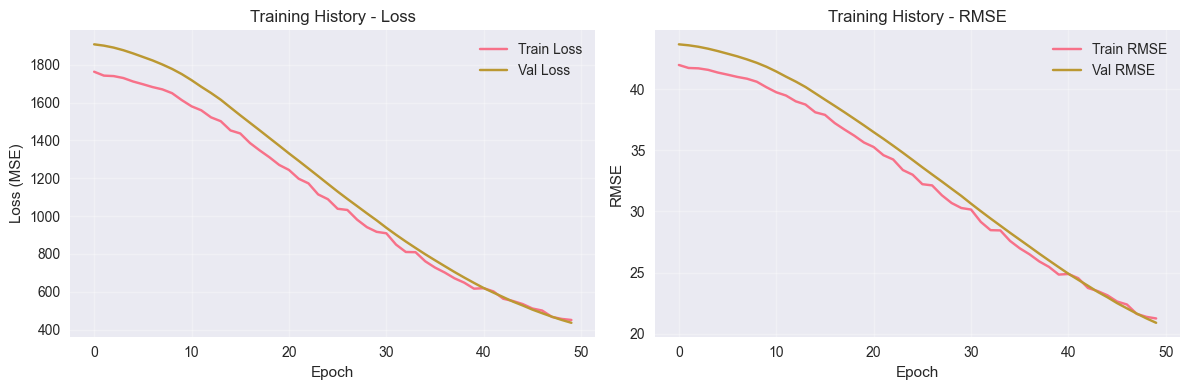

In [11]:
# Visualize training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(val_losses, label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Training History - Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(np.sqrt(train_losses), label='Train RMSE')
axes[1].plot(np.sqrt(val_losses), label='Val RMSE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Training History - RMSE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [12]:
# Save model and results
models_dir = project_root / "results" / "models"
models_dir.mkdir(parents=True, exist_ok=True)

# Save model state dict
model_path = models_dir / "lstm_pytorch_point_model.pth"
torch.save(model.state_dict(), model_path)
print(f"✅ Saved model: {model_path}")

# Save scaler
scaler_path = models_dir / "lstm_pytorch_scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"✅ Saved scaler: {scaler_path}")

# Save model architecture info (needed for loading)
model_info = {
    'input_size': len(feature_cols),
    'hidden_size1': 64,
    'hidden_size2': 32,
    'dropout': 0.2,
    'sequence_length': sequence_length
}
import json
info_path = models_dir / "lstm_pytorch_model_info.json"
with open(info_path, 'w') as f:
    json.dump(model_info, f)
print(f"✅ Saved model info: {info_path}")

# Save predictions
results = pd.DataFrame({
    'actual_rul': y_test_seq,
    'predicted_rul': test_preds
})

results_path = models_dir / "lstm_pytorch_predictions_point.csv"
results.to_csv(results_path, index=False)
print(f"✅ Saved predictions: {results_path}")

# Save metrics
metrics = pd.DataFrame({
    'metric': ['MAE', 'RMSE', 'R²', 'MAPE'],
    'train': [train_metrics['mae'], train_metrics['rmse'], train_metrics['r2'], train_metrics['mape']],
    'test': [test_metrics['mae'], test_metrics['rmse'], test_metrics['r2'], test_metrics['mape']]
})

metrics_path = models_dir / "lstm_pytorch_metrics_point.csv"
metrics.to_csv(metrics_path, index=False)
print(f"✅ Saved metrics: {metrics_path}")

print(f"\n📊 Summary:")
print(f"   Test MAE: {test_metrics['mae']:.2f} cycles")
print(f"   Test RMSE: {test_metrics['rmse']:.2f} cycles")
print(f"   Test R²: {test_metrics['r2']:.3f}")
print(f"\n✅ Phase 1 Complete: PyTorch LSTM point prediction model saved!")
print(f"   Next: Add Monte Carlo Dropout in Phase 2 (much easier in PyTorch!)")


✅ Saved model: /Users/siddhantaggarwal/Desktop/Battery_RUL/results/models/lstm_pytorch_point_model.pth
✅ Saved scaler: /Users/siddhantaggarwal/Desktop/Battery_RUL/results/models/lstm_pytorch_scaler.pkl
✅ Saved model info: /Users/siddhantaggarwal/Desktop/Battery_RUL/results/models/lstm_pytorch_model_info.json
✅ Saved predictions: /Users/siddhantaggarwal/Desktop/Battery_RUL/results/models/lstm_pytorch_predictions_point.csv
✅ Saved metrics: /Users/siddhantaggarwal/Desktop/Battery_RUL/results/models/lstm_pytorch_metrics_point.csv

📊 Summary:
   Test MAE: 16.74 cycles
   Test RMSE: 20.35 cycles
   Test R²: 0.159

✅ Phase 1 Complete: PyTorch LSTM point prediction model saved!
   Next: Add Monte Carlo Dropout in Phase 2 (much easier in PyTorch!)
